## Air.csv collector in one file
1.  static - data 폴더에 2개 이상 화일을 넣는다
1. 자동으로 모든 화일을 합병하고 중복 데이터를 제거한다.
1. 필요 충족조건
  - 한 개 이상의 CSV 화일이 있어야 함.
  - 종자 화일 (이제까지 모아진 Root)을 하나 넣어야 함.    
     (앞에 오는 화일(종자화일)은 데이터에 결함이 없는게 좋다:결측지 보정완료)
  - 여러개의 화일을 자동으로 Merge 한 후에, 최종화일 1개를 추가 생성한다.
  - 최종화일 1개의 정보(그래프)를 보여주니.. 올바른 데이터가 생성됬는지 확인필요!.
1. SAVE로그는 화일정보 기반이 아니라 Datetime.now()임.(그러니 바로 하는게 좋다!)  

In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from asset.config import *
from asset.simple_plot import df_plot
from asset.get_savelog import get_savelog


# dir_work,
# dir_data,
# dir_data_collect,
# dir_data_realtime,
# dir_data_trash,
# dir_img,
# dir_img_heatmap,
# dir_img_nulschool,
# dir_img_plot_plot,
# dir_img_plot_scatter,
# dir_img_result,
# dir_img_test,


# df_plot


# get_savelog()



In [3]:
(SAVE_LOG, SAVE_LOG1) = get_savelog()

In [4]:
ALL_FILES = glob.glob(dir_data_realtime + "/*.csv")     # advisable to use os.path.join as this makes concatenation OS independent

_list = []
for _file in ALL_FILES:
    _df = pd.read_csv(_file, index_col='TIMES', header=0)
    _list.append(_df)

df = pd.concat(_list, axis=0, ignore_index=False)
df.info()    

<class 'pandas.core.frame.DataFrame'>
Index: 370 entries, 2019.01/09(Wed)-01:00 to 2019.01/10(Thu)-01:00
Data columns (total 7 columns):
Time     370 non-null object
SO2      370 non-null float64
NO2      370 non-null float64
O3       370 non-null float64
CO       370 non-null float64
PM10     370 non-null int64
PM2.5    370 non-null float64
dtypes: float64(5), int64(1), object(1)
memory usage: 23.1+ KB


In [5]:
print(df.shape)
df.head()

(370, 7)


,Time,SO2,NO2,O3,CO,PM10,PM2.5
TIMES,,,,,,,
2019.01/09(Wed)-01:00,2019-01-09 01:00:00,0.005,0.008,0.028,0.6,33,12.0
2019.01/09(Wed)-02:00,2019-01-09 02:00:00,0.005,0.009,0.027,0.5,33,13.0
2019.01/09(Wed)-03:00,2019-01-09 03:00:00,0.005,0.011,0.025,0.6,35,14.0
2019.01/09(Wed)-04:00,2019-01-09 04:00:00,0.006,0.012,0.024,0.5,35,13.0
2019.01/09(Wed)-05:00,2019-01-09 05:00:00,0.007,0.016,0.020,0.6,34,16.0


## 단계별 변환을 한번에 바꿈
- dfd = **df.drop_duplicates**(subset='TIMES', keep='first') # ... (128, 11)
 > 1. dfs = **dfd.set_index**('TIMES')    
 >    파생변수: TIMES ... 오름/내림차순 정리가 쉽다 (언제든 다시 만들수 있다.) ... O
 > 1. dfs = **dfd.sort_values**(by=['TIMES'], ascending=1, axis=0)    
 >    **PLOT** 을 할때 인덱스를 따라가기 때문에, 인덱스 정렬이 필요하다 .... NG
- dfn = **dfs.filter**(items=['TIMES', 'Time', 'SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5'])

In [6]:
dfn = df.drop_duplicates(
            # subset='TIMES',      # TIMES 가 인덱스로 걸려서, 활용불가!
            subset='Time', 
            keep='first',
        )\
    .sort_values(
            by=['TIMES'], 
            ascending=1, 
            axis=0,
        )

In [7]:
dfn.head(3)

,Time,SO2,NO2,O3,CO,PM10,PM2.5
TIMES,,,,,,,
2019.01/02(Wed)-01:00,2019-01-02 1:00,0.006,0.017,0.025,0.5,30,18.0
2019.01/02(Wed)-02:00,2019-01-02 2:00,0.006,0.018,0.025,0.5,30,18.0
2019.01/02(Wed)-03:00,2019-01-02 3:00,0.006,0.028,0.015,0.6,35,22.0


In [8]:
dfn.tail(3)

,Time,SO2,NO2,O3,CO,PM10,PM2.5
TIMES,,,,,,,
2019.01/11(Fri)-13:00,2019-01-11 13:00:00,0.011,0.043,0.019,1.0,100,71.0
2019.01/11(Fri)-14:00,2019-01-11 14:00:00,0.010,0.025,0.033,1.0,76,47.0
2019.01/11(Fri)-15:00,2019-01-11 15:00:00,0.009,0.022,0.039,1.0,76,49.0


In [9]:
# 12 / 24시간 인텍스 x라벨을 만든다.
X_INDEX = [_date if _idx is 0 or _idx%24 is 0 else '-' for _idx, _date in enumerate(dfn.index.tolist())]


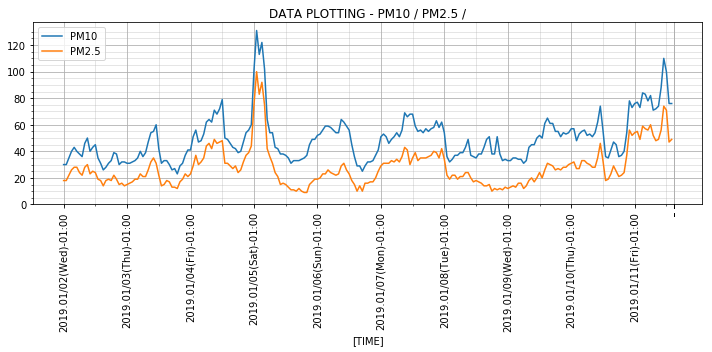

In [10]:
# 전체 플로트
df_plot(
    df_series_list=[
        dfn['PM10'], 
        dfn['PM2.5'],
    ],
    figsize=(10,5),
    xy_start=(0,0),
    xy_max=(
        dfn.index.size,
        np.max(dfn.PM10),
    ),
    xy_major=(24,20),
    xy_minor=(12,5),
)

plt.xticks(X_INDEX, rotation=90)

plt.tight_layout()
plt.savefig(dir_img_result + f'/total_overall_{SAVE_LOG1}.png')

plt.show()


In [11]:
print(f"마지막 기록 = {SAVE_LOG}.... {SAVE_LOG1}")

마지막 기록 = 20190111_Fri_1500.... 20190111_1500_Fri


In [12]:
# Data Frame 을 엑셀로 저장한다. (CSV화일)
dfn.to_csv(dir_data_collect +  f"/_air_{SAVE_LOG}.csv", sep=',', encoding='utf-8')